In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import operator# rank the dictionary
import warnings
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("/Users/Lucinda/Desktop/652/house_price/train.csv")
test = pd.read_csv("/Users/Lucinda/Desktop/652/house_price/test.csv")

In [4]:
train.shape

(1460, 81)

### Descending Correlation Matrix

In [5]:
corr_matx = train.select_dtypes(include=['float64','int64']).iloc[:,1:].corr()

In [6]:
corr_matx

In [7]:
#make a rank of the corelations
corr_matrix = corr_matx.iloc[:,-1].to_dict()

In [8]:
sorted_cor = sorted(corr_matrix.items(), key = operator.itemgetter(1), reverse = True) 

In [9]:
del sorted_cor[0]
#sorted_cor

In [10]:
df_corr = pd.DataFrame(sorted_cor, columns = ['feature', 'correlation'])

In [112]:
print('List the numerical features decendingly by their correlation with sales price',df_corr)

List the numerical features decendingly by their correlation with sales price           feature  correlation
0     OverallQual     0.790982
1       GrLivArea     0.708624
2      GarageCars     0.640409
3      GarageArea     0.623431
4     TotalBsmtSF     0.613581
5        1stFlrSF     0.605852
6        FullBath     0.560664
7    TotRmsAbvGrd     0.533723
8       YearBuilt     0.522897
9    YearRemodAdd     0.507101
10    GarageYrBlt     0.486362
11     MasVnrArea     0.477493
12     Fireplaces     0.466929
13     BsmtFinSF1     0.386420
14    LotFrontage     0.351799
15     WoodDeckSF     0.324413
16       2ndFlrSF     0.319334
17    OpenPorchSF     0.315856
18       HalfBath     0.284108
19        LotArea     0.263843
20   BsmtFullBath     0.227122
21      BsmtUnfSF     0.214479
22   BedroomAbvGr     0.168213
23    ScreenPorch     0.111447
24       PoolArea     0.092404
25         MoSold     0.046432
26      3SsnPorch     0.044584
27     BsmtFinSF2    -0.011378
28   BsmtHalfBath    -0

* for numerical features, overall quality, grliv area, and garage cars and garageareas have high relations with the 
sales price, therefore, I will do a feature selection for these features. 

### Minor Visualization

In [12]:
x_axixs = df_corr.feature.values

In [13]:
x_axixs

array(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces',
       'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF',
       'OpenPorchSF', 'HalfBath', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF',
       'BedroomAbvGr', 'ScreenPorch', 'PoolArea', 'MoSold', '3SsnPorch',
       'BsmtFinSF2', 'BsmtHalfBath', 'MiscVal', 'LowQualFinSF', 'YrSold',
       'OverallCond', 'MSSubClass', 'EnclosedPorch', 'KitchenAbvGr'], dtype=object)

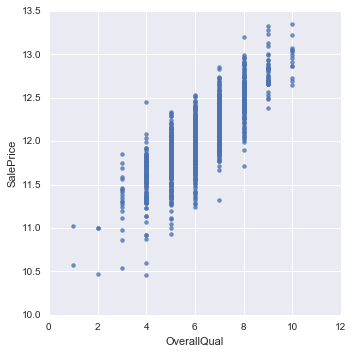

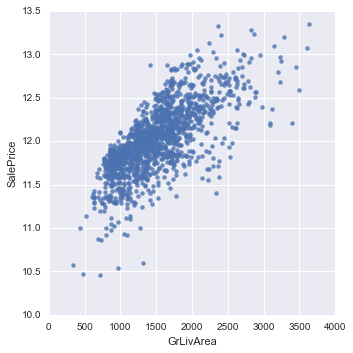

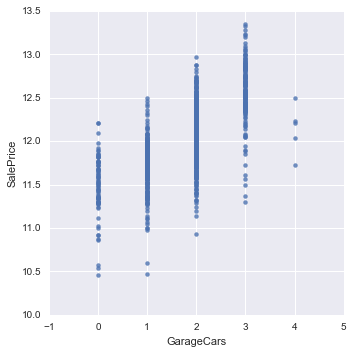

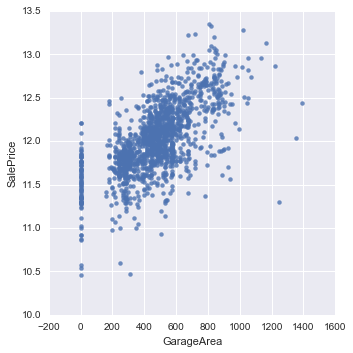

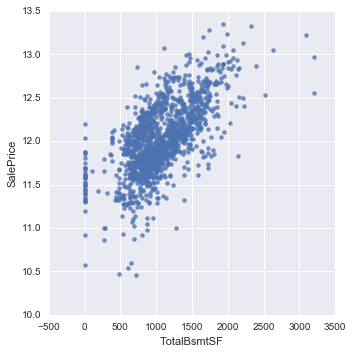

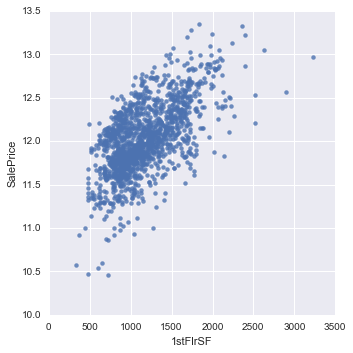

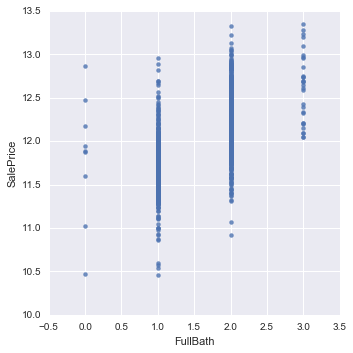

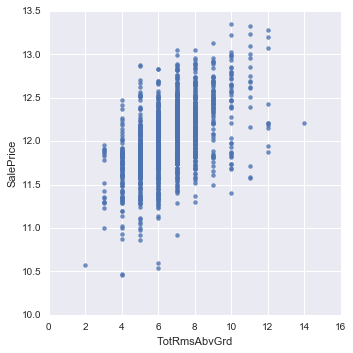

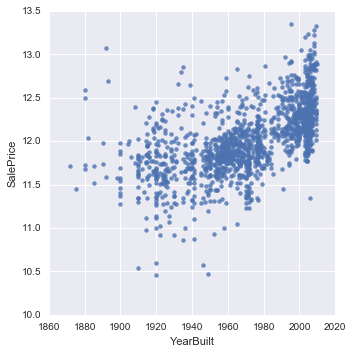

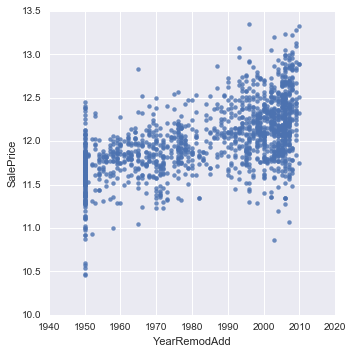

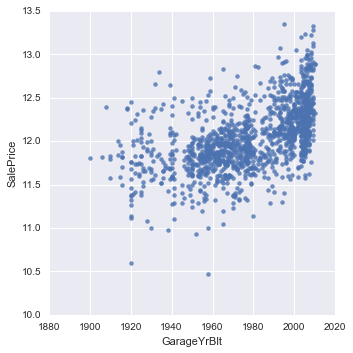

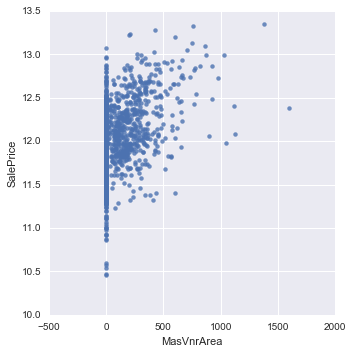

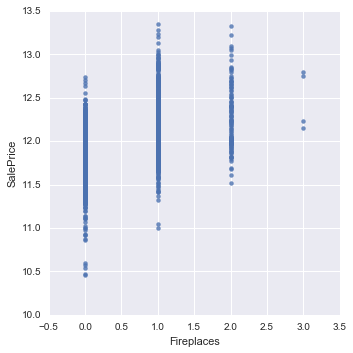

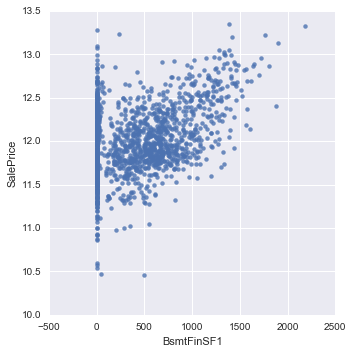

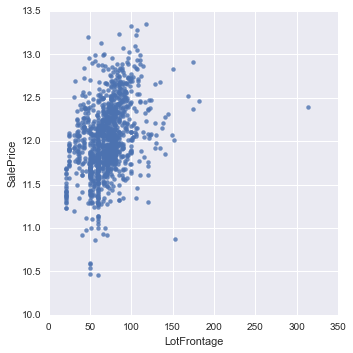

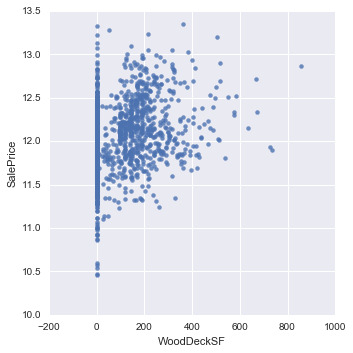

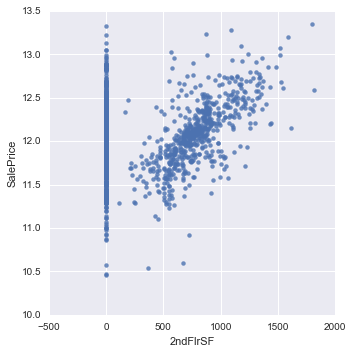

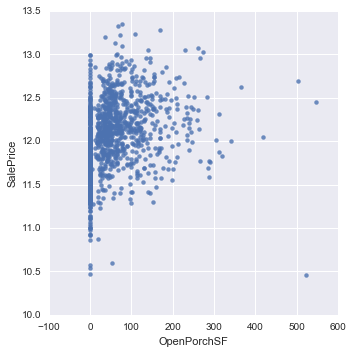

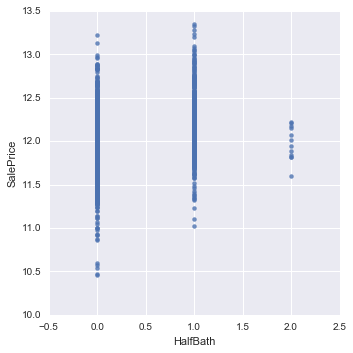

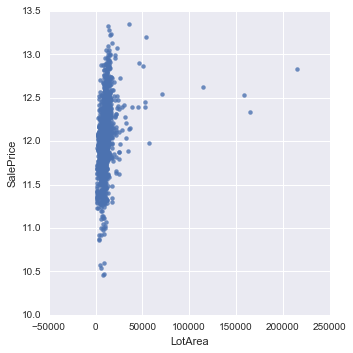

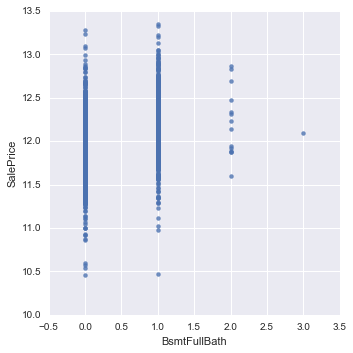

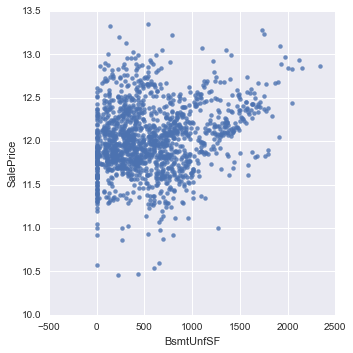

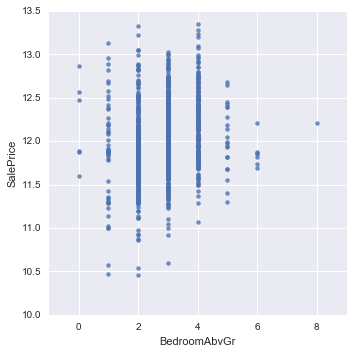

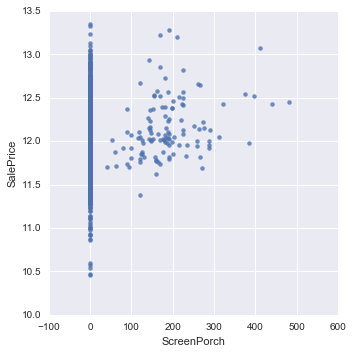

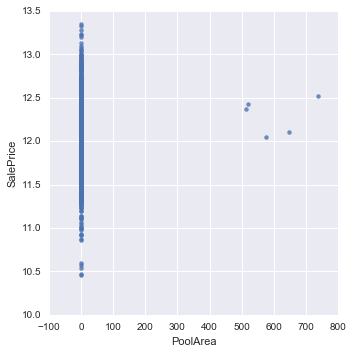

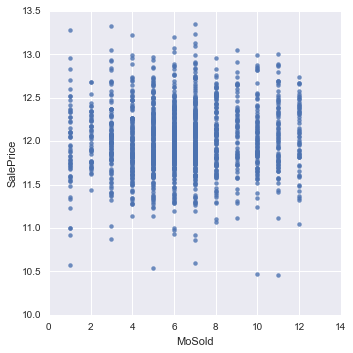

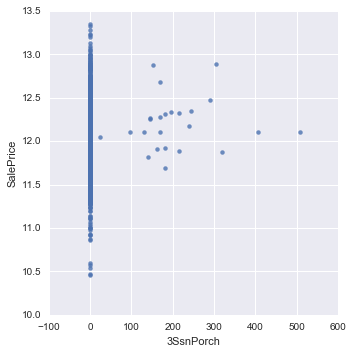

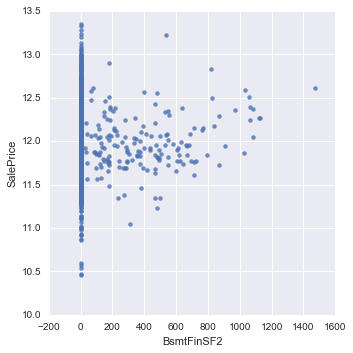

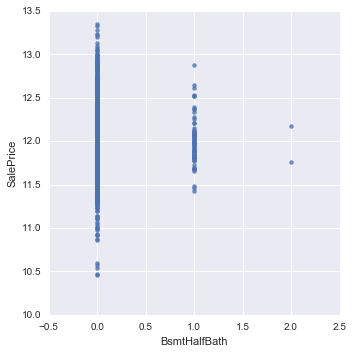

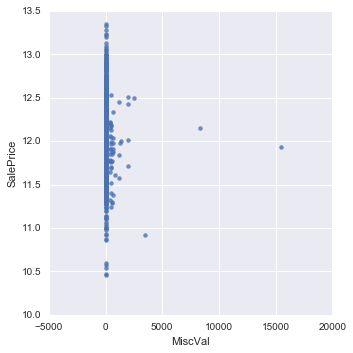

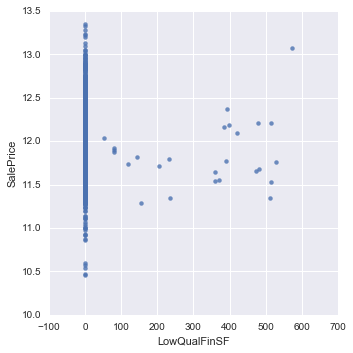

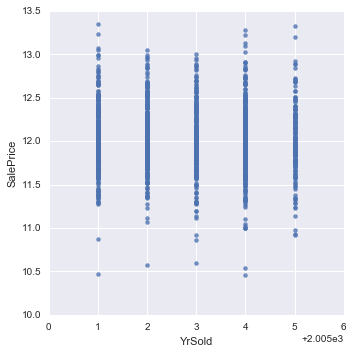

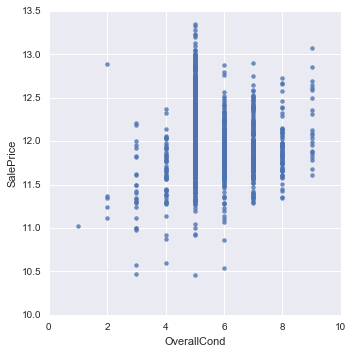

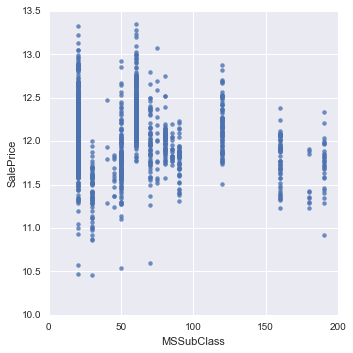

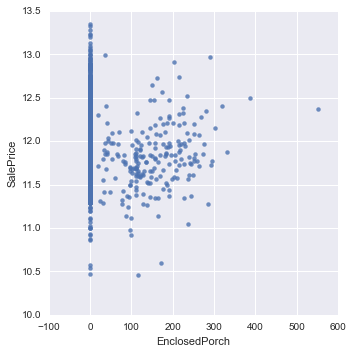

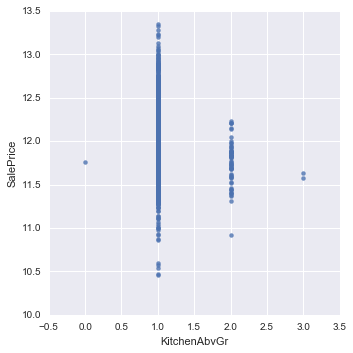

In [102]:
for each in x_axixs:
    sns.lmplot(x = each, y = 'SalePrice',  data = train, fit_reg = False)

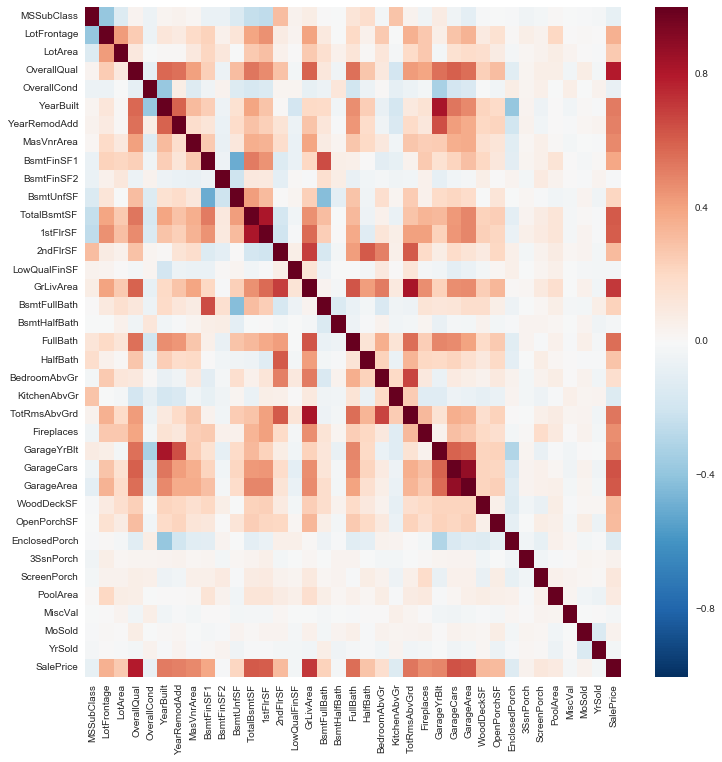

In [103]:
plt.figure(figsize = (12,12))
sns.heatmap(corr_matx, vmax = 1)

### Drop the outliers

In [15]:
train.drop(train[train['GrLivArea'] > 4000].index, inplace = True)

### Data preprocessing:


* First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more  normal
* Create Dummy variables for the categorical features
* Replace the numeric missing values (NaN's) with the mean of their respective columns

'\nmatplotlib uses matplotlibrc configuration files to customize all kinds of properties, \nwhich we call rc settings or rc parameters.\nfigure size in inches\n字母排序, Calculates log(1 + x).\n'

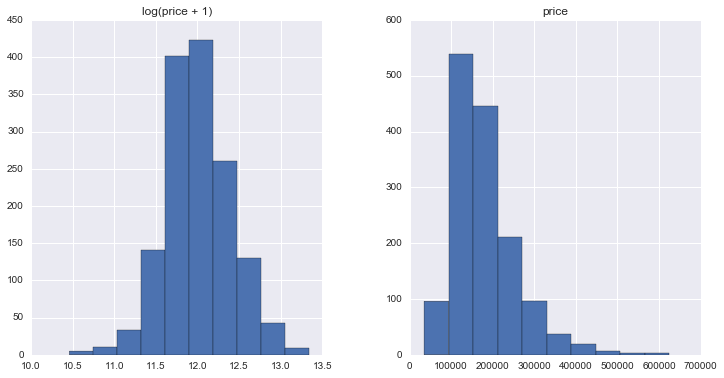

In [16]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"log(price + 1)":np.log1p(train["SalePrice"]),"price":train["SalePrice"]})
prices.hist()
'''
matplotlib uses matplotlibrc configuration files to customize all kinds of properties, 
which we call rc settings or rc parameters.
figure size in inches
字母排序, Calculates log(1 + x).
'''

In [17]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [18]:
#log transfrom the target
train["SalePrice"] = np.log1p(train['SalePrice'])

# log transform skewed numeric features
numeric_features = all_data.dtypes[all_data.dtypes != 'object'].index

skewed_features = train[numeric_features].apply(lambda x: skew(x.dropna())) #datafram.dropna()
skewed_features = skewed_features[skewed_features> 0.75]
skewed_features = skewed_features.index

all_data[skewed_features] = np.log1p(all_data[skewed_features])

In [19]:
all_data_dummies = pd.get_dummies(all_data)

In [20]:
#filling Na's with the mean of the column
all_data_dummies = all_data_dummies.fillna(all_data_dummies.mean())

In [21]:
# creating matrics for sklearn
X_train = all_data_dummies[:train.shape[0]] # : ?
X_test = all_data_dummies[train.shape[0]:]
Y_train = train['SalePrice']

### Ridge Model

Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error(root mean square error) so we can evaluate our models and pick the best tuning par


In [55]:
from sklearn.linear_model import Ridge, RidgeCV,ElasticNet, LassoCV, LassoLarsCV
from sklearn.cross_validation import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model,X_train,Y_train, scoring = 'neg_mean_squared_error', cv = 5))
    return(rmse)

In [56]:
model_ridge = Ridge()
model_ridge

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [57]:
alphas = [0.05, 0.1,0.15, 0.2, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

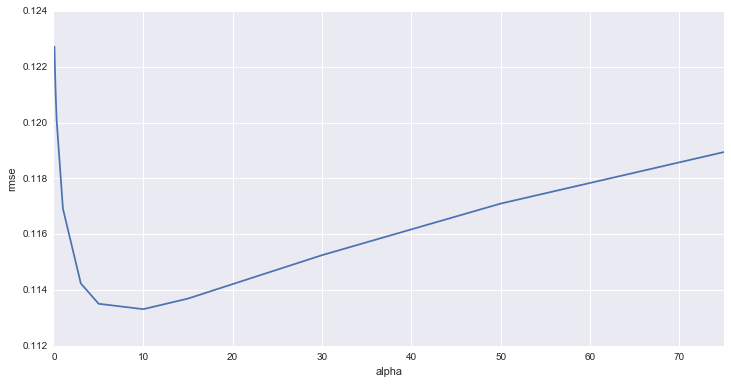

In [31]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot()
plt.xlabel('alpha')
plt.ylabel('rmse')


In [32]:
alpha = model_ridge.alpha
print('the best alpha:',alpha)

print("Try again for more precision with alphas centered around " + str(alpha))

ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, Y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)


the best alpha: 1.0
Try again for more precision with alphas centered around 1.0
Best alpha : 1.4


In [58]:
cv_ridge = rmse_cv(ridge).mean()

In [34]:
cv_ridge.mean()

0.11599530661799273

* So for the ridge regression model, the rmse is about 0.117
* The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

### Lasso

* So for the Lasso regression model, the rmse is about 0.12

In [91]:
alpha_l = [1,0.5, 0.1, 0.01,0.001, 0.0005,0.0001]
model_lasso = LassoCV(alphas= alpha_l).fit(X_train, Y_train)
cv_lasso = rmse_cv(model_lasso)
print("Mean: ", cv_lasso.mean())
print("Min: ", cv_lasso.min())

Mean:  0.110239910055
Min:  0.10213014251


In [72]:
alpha_l

[1, 0.5, 0.1, 0.01, 0.001, 0.0005, 0.0001]

In [73]:
cv_lasso

array([ 0.10625917,  0.11126065,  0.12145876,  0.10213014,  0.11009082])

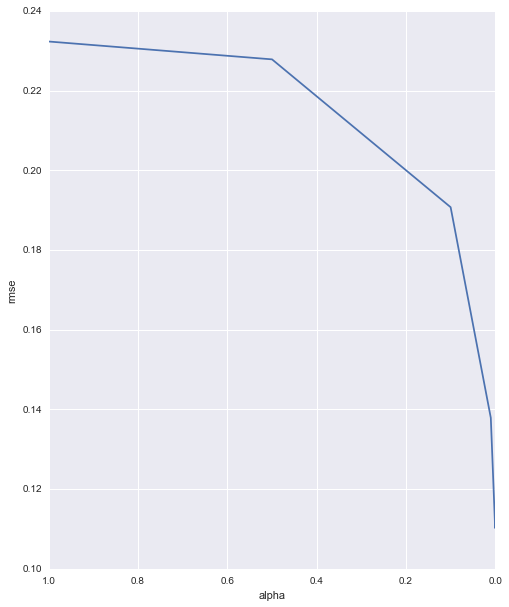

In [74]:
cv_lasso = [rmse_cv(LassoCV(alphas= [alpha])).mean() for alpha in alpha_l]

cv_lasso = pd.Series(cv_lasso, index = alpha_l)
cv_lasso.plot()
plt.xlabel('alpha')
plt.ylabel('rmse')

In [78]:
#select precise alpha_L
alpha_L = model_lasso.alpha_
print('Best alpha:',alpha_L)

print('Try again for more precise alpha around ',alpha_L )
lasso = LassoCV(alphas=[alpha_L * .6, alpha_L * .65, alpha_L * .7, alpha_L * .75, alpha_L * .8, alpha_L * .85, 
                          alpha_L * .9, alpha_L * .95, alpha_L, alpha_L * 1.05, alpha_L * 1.1, alpha_L * 1.15,
                          alpha_L * 1.25, alpha_L * 1.3, alpha_L * 1.35, alpha_L * 1.4], 
                cv = 10)
#alpha_L2 = lasso.alpha_
#print('Best alpha:', str(alpha_L2))

Best alpha: 0.0005
Try again for more precise alpha around  0.0005


In [37]:
alpha = model_lasso.alpha_
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, Y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

Best alpha : 0.00035


In [60]:
cv_lasso2 = rmse_cv(lasso)
print("Mean: ", cv_lasso2.mean())
print("Min: ", cv_lasso2.min())

Mean:  0.110399960735
Min:  0.102204927059


In [39]:
lasso.alpha_

0.00035

In [40]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [41]:
print("Lasso picked " , str(sum(coef != 0)), "variables and eliminated the other", str(sum(coef == 0)), 'variables')

Lasso picked  105 variables and eliminated the other 182 variables


In [42]:
imp_coef = pd.concat([coef.sort_values().head(10),
                    coef.sort_values().tail(10)])


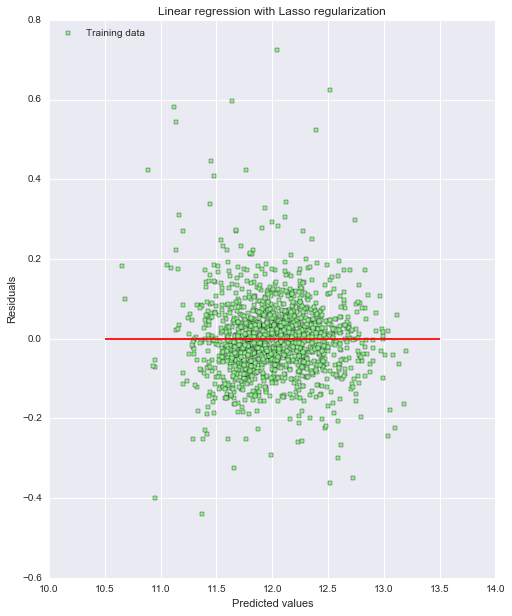

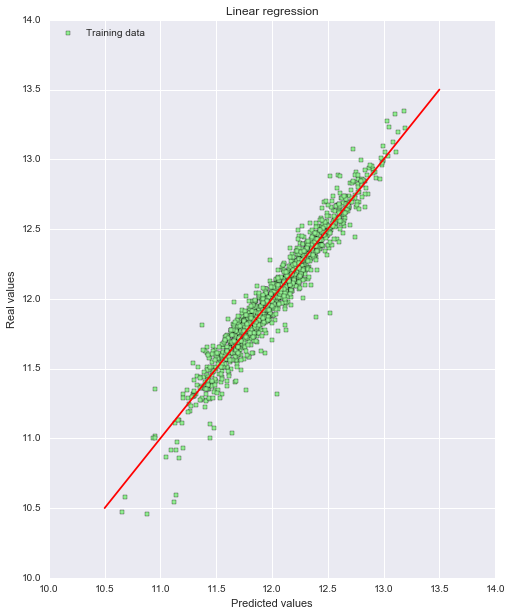

In [100]:
Y_train_las = model_lasso.predict(X_train)
Y_test_las = model_lasso.predict(X_test)
# Plot residuals

plt.scatter(Y_train_las, Y_train_las - Y_train, c = "lightgreen", marker = "s", label = "Training data")
#plt.scatter(Y_test_las, Y_test_las - Y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(Y_train_las, Y_train, c = "lightgreen", marker = "s", label = "Training data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()


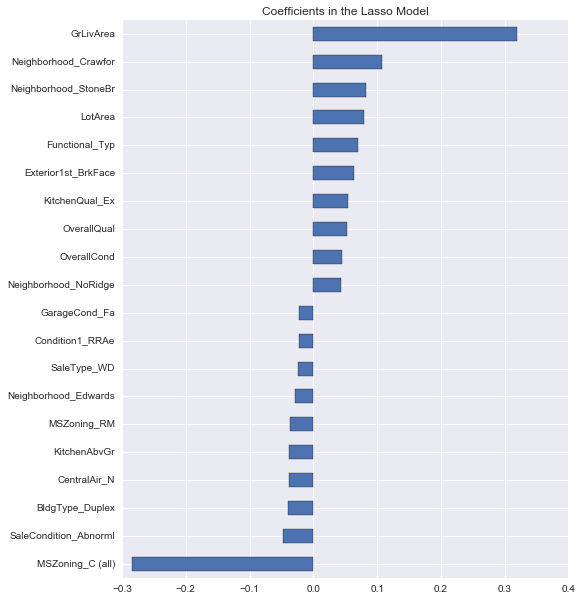

In [43]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 10
imp_coef.plot(kind = 'barh')
plt.title("Coefficients in the Lasso Model")

### ADDing XGBoost

In [80]:
import xgboost as xgb

In [81]:
dtrain = xgb.DMatrix(X_train, label = Y_train)
dtest = xgb.DMatrix(X_test)

In [82]:
parmas = {"max_depth" : 2, "eta": 0.1}
#model = xgb.cv(parmas, dtrain, num_boost_round= 500, early_stopping_rounds= 100)

In [83]:
model_xgb = xgb.XGBRegressor(n_estimators= 5000, max_depth= 3, learning_rate= 0.1,
                            gamma = 0, subsample = 0.8, colsample_bytree = 0.8,
                             colsample_bylevel=0.8, nthread = 4,seed = 0)
model_xgb.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=0.8, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=5000, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [84]:
xgb_preds = np.expm1(model_xgb.predict(X_test))

In [85]:
cv_xgb = rmse_cv(model_xgb)
print("Mean: ", cv_xgb.mean())
print("Min: ", cv_xgb.min())

Mean:  0.117934539094
Min:  0.108708510854


### Submission

In [87]:
Lasso_pred = np.expm1(model_lasso.predict(X_test))
#pd.DataFrame

In [108]:
Lasso_pred

array([ 122870.16677595,  155358.51364925,  182271.15234992, ...,
        171960.79421276,  118146.62091641,  228242.11560076])

In [110]:
submission = pd.DataFrame()
submission["Id"] = test['Id']
submission['SalePrice'] = Lasso_pred
submission.to_csv('Lasso_Model4.csv', index = False)